## Machine variables

These variables are referenced by the code below and are machine specific- *you need to alter these for some functions to work!* 

The comments indicate what they should be set to and what they are used for.

In [1]:
import os
import tempfile

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

## Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [2]:
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial

In [3]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
import scipy as sp




/home/hz368/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/hz368/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
%load_ext line_profiler
%load_ext memory_profiler

In [5]:
'''
A cell should update to divide and die. As we can only count living cells, 
we only need to measure the lifetime of a cell or experiment, and store its 
siblings.

For the whole clone size, each of the siblings need to be simulated to their
stratification or the end of the experiment.

The cell updates in discrete time, with an aim that randomly generated times 
are projected back on a cohort a posteri to reduce calculation times.
'''
        
class cell:
    def __init__(self,init,stem,r,rng):
        self.currentTime = init
        self.stem = stem
        self.r = r
        self.rng = rng
        self.lifetime = 0
        self.birthtime = self.currentTime
        self.survivor = False
        self.siblings = []
    def printState(self):
        response = "Time\t%d\nStem\t%r\n" % (self.currentTime, self.stem)
        print(response)
    def printParameters(self):
        response = "Lambda\t%f\nr\t%f\nrho\t%f\n" % (self.lam, self.r, self.rho)
        print(response)
    def printHistory(self):
        response = "Siblings\t%d\tBirth\t%f\tDeath\t%f\n" % (len(self.siblings), self.birthtime, self.lifetime)
        print(response)
    def simulate(self,limit):
        cont = True
        while(cont):
            if self.lifetime > 0:
                cont = False
            elif self.currentTime>limit:
                #End experiment- lifetime set to currenttime+1 if not a stem cell, currenttime if stem with surv bool set
                #Infinity is inappropriate as its a float, so setting lifetime to current time
                #If a clone has infinity *before* the last experimental timepoint, the simulation needs extension
                if self.stem:
                    self.survivor = True
                    self.lifetime = self.currentTime
                else:
                    self.lifetime = self.currentTime+1
                cont = False
            else:
                if self.stem:
                    self.currentTime += 1
                    sibling = cell(self.currentTime,self.stem,self.r,self.rng)
                    rand = self.rng.random()
                    if rand < self.r:
                        pass
                    elif rand < (self.r*2):
                        self.stem = False
                        sibling.stem = False
                    else:
                        sibling.stem = False
                    self.siblings.append(sibling)
                else:
                    self.currentTime += 1
                    self.lifetime = self.currentTime
                

'''
Simulates a cell up to an event limit, storing the discrete times only
'''
def cloneSimulateDiscreteTime(i,limit,acc):
    i.simulate(limit)
    acc.append((i.birthtime,i.lifetime))
    for s in i.siblings:
        cloneSimulateDiscreteTime(s,limit,acc)
    return(acc)

'''
Simulates a cell up to an event limit, storing the cell as result
'''
def corecloneSimulateComplete(i,acc,parent,nameMarker,limit):
        i.simulate(limit)
        #update namemarker for a unique name
        nameMarker[0]+=1
        name = nameMarker[0]
        acc.append((i.birthtime,i.lifetime,parent,i.survivor)) #Switching to numpy array here leads to a 20x slowdown!
        for s in i.siblings:
            corecloneSimulateComplete(s,acc,name,nameMarker,limit)
        return((acc)) #adding np.asarray gives 20x slowdown
def cloneSimulateComplete(i,limit):
    return(corecloneSimulateComplete(i,[],-1,[-1],limit))

def experimentDiscreteTime(c,timePoints):
    limit = max(timePoints)
    lifespans = cloneSimulateDiscreteTime(c,limit,[])
    def within(a,b,c):
        if c>a and c<=b:
            return(1)
        else:
            return(0)
    return([sum([within(b,d,t) for (b,d) in lifespans]) for t in timePoints])
    

def printClone(c):
    def core(c,d):
        print("Gen\t%d" % d)
        c.printHistory()
        for i in c.siblings:
            core(i,d+1)
    core(c,0)

def seedExperiment(i):
    random.seed(i)
    return(experimentDiscreteTime(cell(0,True,0.25,random),[2,4,8,10,30,50,100]))

#uni = uniformGenerate(1982,None)
def seedClone(i):
    random.seed(i)
    return(cloneSimulateComplete(cell(0,True,0.25,random),100))

# Converting clone lifespan to realistic times

The fate simulator is able to generate the orders of events in a clones lifetime, but in order to compare this with experimental data we need to use the outputs from that function, and transform them into floating point numbers that reflect the division and stratification rates. The most common way to do this is to draw the division times from an exponential distribution characterised by its mean, but we also know that the exponential distribution is unrealistic for cell division times. Here we explore two alternative distributions used in the literature; a short, deterministic delay (the delay or refractory period) followed by an exponential distribution, and a deterministic lag period followed by times selected from a gamma distribution (with an additional shape parameter). As the exponential distribution is a special case of the gamma distribution where the shape is 1., we can focus on using just the gamma distribution when we start to compare with experimental data.

We first define functions that allow us to set create a random number generator for a given distribution with a specific set of parameters (using the numpy library to generate the underlying distribution). In each case the overall mean time for events to occur and a random number generator is passed to the function. In addition to this, a delay may be passed (either as an absolute delay, or expressed as a fraction of the mean) and a shape parameter. In each case the object returned is a function that takes unit as an input and returns a new floating point number from the distribution.

In each case we use an object that preallocates a large number of random numbers (*total*) and defines functions that return one, or an array of random numbers of a specified size, cumulatively summed. The functions that return values determine whether the store of numbers will run out and regenerates a set periodically. This is written like this for performance purposes. 

In [6]:
class timeGenerate:
    def __init__(self,seed,params):
        np.random.seed(seed)
        self.total = 10000000
        self.params = params
        self.validate()
        #Generate "total" times
        self.regenerate()
    def regenerate(self):
        self.precalculated = np.ones(self.total)
        self.position = 0
    def next(self,n=1):
        if (n+self.position>self.total):
            self.regenerate()
            return(self.next(n))
        else:
            result = np.cumsum(self.precalculated[self.position:self.position+n])
            self.position+=n
            return(result)
    def nextOne(self):
        if (1+self.position>self.total):
            self.regenerate()
            return(self.nextOne())
        else:
            result = self.precalculated[self.position]
            self.position+=1
            return(result)
    def nextTerminated(self,n=1,terminator=None):
        if (n+self.position>self.total):
            self.regenerate()
            return(self.next(n))
        else:
            times = self.precalculated[self.position:self.position+n]
            #This replaces a value! it will not be reused and eventually will be regenerated though
            times[-1] = terminator.nextOne()
            result = np.cumsum(times)
            self.position+=n
            return(result)
    def validate(self):
        pass
    def drawTimes(self,limit):
        counter = 0
        totalTime=0
        while(totalTime<limit):
            totalTime+=self.precalculated[self.position+counter]
            counter+=1
            if counter+self.position>self.total:
                self.regenerate()
                return(self.drawtimes(limit))
        return(self.next(counter))
        

class halfTime(timeGenerate):
    def regenerate(self):
        self.precalculated = np.ones(self.total)/2
        self.position = 0
        
class exponentialGenerate(timeGenerate):
    def regenerate(self):
        (mean) = self.params
        self.precalculated = np.random.exponential(mean,self.total)
        self.position = 0

class uniformGenerate(timeGenerate):
    def regenerate(self):
        #(lower,upper) = self.params
        self.precalculated = np.random.uniform(0,1,self.total)
        self.position = 0

class exponentialGenerateDelay(timeGenerate):
    def regenerate(self):
        (mean,delay) = self.params
        self.precalculated = np.random.exponential((mean-delay),self.total)+delay
        self.position = 0
    def validate(self):
        assert(self.params[0]>self.params[1])

class gammaGenerate(timeGenerate):
    def regenerate(self):
        (shape,scale) = self.params
        self.precalculated = np.random.gamma(shape,scale,self.total)
        self.position = 0

class gammaGenerateDelay(timeGenerate):
    def regenerate(self):
        (mean,shape,delay) = self.params
        scale = (mean-delay)/shape
        self.precalculated = np.random.gamma(shape,scale,self.total)+delay
        self.position = 0
    def validate(self):
        assert(self.params[0]>self.params[2])

#More elegant way of expressing the delay
class gammaGenerateFractionalDelay(timeGenerate):
    def regenerate(self):
        (mean,shape,delay) = self.params
        scale = (mean*(1-delay))/shape
        self.precalculated = np.random.gamma(shape,scale,self.total)+delay*mean
        self.position = 0
    def validate(self):
        assert(0<=self.params[2])
        assert(self.params[2]<=1)

## Converting discrete time to real time

The function *correctTime* below takes two random number generator objects (of the type we have just defined above), an initial time, and an array of tuples generated by the cloneSimulate function defined above. It returns a new array with the time of birth and the time of loss of the cell. 

To do this we first generate an array with random numbers drawn from the function representing the division times. If the cell stratifies we replace the last number in the array with a value drawn from the function representing stratification times. Finally, we perform a cumulative sum so that all elements represent the times taken for each event to happen from an initial timepoint (here arbitrarily set to zero).

This gives us a series of timepoints that are accurate relative to the time when the cell was first born. However, we need the times to be relative to the start of the experiment to be useful. To do this for each cell we need to look at the times of its parent (and in turn, its parents and grandparents until the original cell) and adjust all the timepoints by the time the cell was born. Uniquely, the original cell has a parent set to a negative value and if this is found in the loop, the initial time is set to the value passed when calling the function.

As an example, we want to generate times for the third cell in a clone. The third cell is a daughter of the first. The discrete times are 

cell 1 born @ 0, lost @ 3
cell 3 born @ 1, lost @ 2

This will give us initially two arrays of timepoints;

cell1 = [|0.;0.5;1.0;1.5;|]
cell3 = [|0.;1.0|]

For cell 3, assuming that the initial time of the experiment was 0 (so cell 1 remains unchanged), we then need to add 0.5 (the first time from cell 1) to every timepoint. We get this by using the discrete birthtime as an index in the array. Finally, we return the first and last elements of the new array as the time of birth and the time of death; 0.5 and 1.5.

This relies on being able to look up the parent time. Earlier we sorted the array returned by cloneSimulate by the unique identifier- this allows us to use the parent id (stored in the tuple) as an index in the original search. It also ensures that we correct the times in order of cell creation- this is important as when we correct the times we mutate the values in the original array, and ensures that we have always corrected the parents before we update their children. 

We now have enough information to directly compare our results with lineage tracing data.

In [7]:
def correctTime(c,initial,division,stratification,limit):
    #c is tuple of birth,death,parent,survival (int*int*int*bool)
    #First get all the relative times for all the clones, measured from birth. 
    eventTimes = [((division.next(d-b),b,d,p) if s else (division.nextTerminated(d-b,terminator=stratification),b,d,p) ) for (b,d,p,s) in c ]

    #Second correct the intial times of all of the events and store to the acc
    def includeBirth(times,birthday,deathday,parent):
        #modifier is going to be calculated from the birthtime, and the time of the parent
        #this relies on mutables. Potential for ugliness
        #Your parent's life times are stored by index- so if you parent is x, the lifetimes are in eventTimes[x]
        #Times are in the first element of the eventTimes tuple- eventTimes[x][0]
        #Your birthday (n) is the (n-1)th event in the parents life- so its in eventTimes[x][0][n-1*]
        #Your parents birthday needs to be taken into account too; so if your parent was born on 3 and you on 6 you need n-pbday-1
        #print(times)
        if parent<0:
            #special case- the initial cell
            times+=initial
            return((initial,times[-1])) 
        else:
            parentBirthday = eventTimes[parent][1]
            timeOnBirth=eventTimes[parent][0][birthday-parentBirthday-1]
            if(len(times)):
                times+=timeOnBirth
                return( (timeOnBirth, times[-1] ) )
            else:
                #special case- this is a cell born on the last time point. Arbitrarily set to infinity
                #Note differentiated cells born on the last timepoint have their lifetime extended, so this is only stem cells
                return((timeOnBirth,math.inf))
    acc = [includeBirth(times,birthday,deathday,parent) for (times,birthday,deathday,parent) in eventTimes]

    return(acc)

## Comparing models with experiments
Here we will take the simulators we have created and use them to search an experimental dataset for parameters that describe the model well. We will take some published data of measured clone sizes, make a plot to show that it has some of the expected properties (specifically, linearly increasing average clone size over time). We will then use a set of simulations to estimate the likelihoods of different parameter combinations for models, and identify the most likely combination by plotting the results as a heatmap.

To interpret the heatmaps, the parameter combinations with the highest likelihood are the best fitting. For this dataset, we can see that for both exponential and gamma distributions we find low values of $r$ and high values of $\rho$ best describe the data. We can further see that the choice of distribution makes subtle differences on the long term distributions.

In [8]:
def getLineage(filename):
    #reads a tsv file of clone counts
    df = pd.read_csv(filename, sep="\t")
    counts = np.transpose(df.values).astype(float)
    header = df.columns.values
    return(header[1:].astype(float),counts[1:])

In [9]:
times, counts = getLineage("DoupeAggregate.tsv")

In [10]:
experiment = [[np.repeat(i+1, counts[t][i]) for i in range(max(np.where(counts[t]>0)[0]))] for t in range(len(counts))]

In [11]:
experimentList = [np.concatenate(t, axis = None) for t in experiment]
experimentList[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3])

### Exploring the data

We showed that the simulations showed a linear growth in average clone size over time. Here we repeat the test on the experimental data.

In [12]:
def quantileStatistic(o,m):
    oq = np.quantile([a for a in o if a > 0],[0.025,0.25,0.5,0.75,0.975])
    mq = np.quantile([b for b in m if b > 0],[0.025,0.25,0.5,0.75,0.975])
    r = sp.absolute(oq-mq)
    return(sum(r))    
        
def ksStatistic(o,m):
    k,p = stats.ks_2samp([a for a in o if a > 0],[b for b in m if b >0])
    return(k)

In [13]:
# def logLikelihood(obs,lp):
#     if len(obs) > len (lp):
#         maxClone = len(lp)
#     else:
#         maxClone = len(obs)
#     def noisyMul(a,b,i):
#         #print("logP",lp, "\nobsv", obs); lp[i]*obs[i]
#         print("logP",a, "\nobsv", b)
#         return(a[i]*b[i])
#     return(sum([obs[i]*lp[i] for i in range(maxClone)]))

# def allLogLike(obs,lp):
#     return(sum([logLikelihood(o,p) for o,p in zip(obs,lp)]))

# def sizesToFreq(sizes, data):
#     biggest = max([max(c) for c in sizes])
#     #print("Mean:",(sum(sizes)*surv))
#     sizeList = [[t.count(s+1) for s in range(biggest)] for t in sizes]
#     probability = [np.array(t)/sum(t) for t in sizeList]
#     total = [sum(t) for t in data]
#     freq = [(p*o) for p,o in zip(probability,total)]
# #     logFreq = [[0 if total==0 or item==0 else math.log10(item/total) for item in n] for n,total in zip(sizeList,countPerTimePoint)]
#     return(freq)
    
def fateToFrequency(timePoints,fates,generations,div,strat,data):
    times = np.asarray([np.asarray(correctTime(c,0,div,strat,generations)) for c in fates])
    #count clone sizes at timepoints
    def within(birth,death,time):
        if time>=birth and time<death:
            return(1)
        else:
            return(0)
    cloneSizes = [[sum([within(cell[0],cell[1],t) for cell in clone]) for clone in times ] for t in timePoints]
    #for i,t in enumerate(cloneSizes):
    #    print(i,sum(t),t.count(0))
    #convert to log10(frequency)
#     freq = sizesToFreq(cloneSizes,data)
    return(cloneSizes)

def parameterLike(rho,meanDivTime,timePoints,fates,generations,div,seed,data):
    #print("rho =",rho)
    stratTime = (1-rho)*meanDivTime/rho
    #print("\tstrat =",stratTime)
    strat = exponentialGenerate(seed,(stratTime))
    #Now get the probabilities
    sim = fateToFrequency(timePoints,fates,generations,div,strat,data)
    #Now get the likelihoods
#     like = allLogLike(data,lp)
    #print(like)
    d = [quantileStatistic(data[i],sim[i]) for i in range(len(data))]
    return(sum(d))

def searchRho(timePoints,r,sampleSize,seed,div,meanDivTime,data):
    #print("r =",r)
    random.seed(seed)
    generations = 230 
    def seedWrapper(r,generations,seed):
        random.seed(seed)
        clone = cell(0,True,r,random)
        return(cloneSimulateComplete(clone,generations))
    fates = np.asarray( [np.asarray(seedWrapper(r,generations,i)) for i in range(sampleSize)] )
    #check fate survival is sound
    def within(birth,death,time):
        if time>=birth and time<death:
            return(1)
        else:
            return(0)
    cloneSizes = [[sum([within(b,d,t/meanDivTime) for (b,d,p,s) in clone]) for clone in fates ] for t in timePoints]
    #for i,t in enumerate(cloneSizes):
    #    print(i,sum(t),t.count(0))
    rho = r/0.12
    return(parameterLike(rho,meanDivTime,timePoints,fates,generations,div,seed,data))
    
def calculateDistance(div,meanDivTime,data,bins,timePoints):
#     rhoVals = [(i/bins) for i in range(1,bins)] 
    rVals = [(i*0.12/bins) for i in range(1,bins)] 
    #print("Testing:",rVals,rhoVals)
    sampleSize = 10000
    result = np.array([searchRho(timePoints,r,sampleSize,seed,div,meanDivTime,data) for (seed,r) in enumerate(rVals)])
    return(result)

In [14]:
bins = 50
expRate = exponentialGenerate(102,(2.4))
%time e = calculateDistance(expRate,2.4,experimentList,bins,times)

CPU times: user 56min 25s, sys: 5.58 s, total: 56min 30s
Wall time: 56min 30s


In [15]:
# def plotDistance(e):
#     #Does some transformations to ensure that the graph is square, 
#     # with r on x axis and rho on y, both increasing from bottom left
#     plt.imshow((np.flip(np.transpose(e),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0,0.2,0,1],aspect=0.2)
#     x = np.linspace(0,0.1,50)
#     y = x/0.12
#     plt.plot(x, y, '-c')
#     plt.colorbar()
#     plt.show()

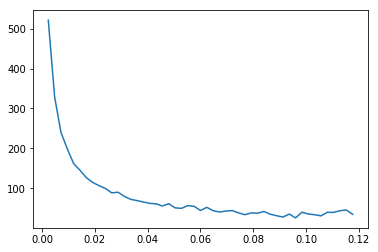

In [16]:
plt.plot(np.array([(i*0.12/bins) for i in range(1,bins)]),e)
plt.show()

In [17]:
gamRate = gammaGenerateDelay(102,(2.4,8.,0.5))
%time g = calculateDistance(gamRate,2.4,experimentList,bins,times)

CPU times: user 59min 2s, sys: 14.3 s, total: 59min 16s
Wall time: 56min 56s


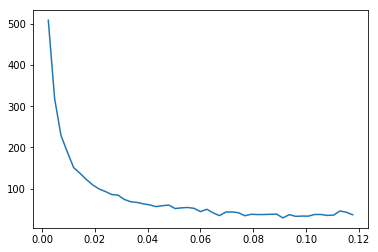

In [18]:
plt.plot(np.array([(i*0.12/bins) for i in range(1,bins)]),g)
plt.show()

In [19]:
# pickle_out = open("pickled_quantile_exp","wb")
# pickle.dump(e, pickle_out)
# pickle_out.close()

In [20]:
# pickle_out = open("pickled_quantile_gamma","wb")
# pickle.dump(g, pickle_out)
# pickle_out.close()